## Set-Up

In [3]:
# Imports
import numpy as np
from numpy import concatenate
from pandas import read_csv, DataFrame, concat, to_datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [4]:
# Define global variables
num_features = 1
target_variable = 'AAPL'
lag_steps = 1

In [5]:
df = read_csv('../../data/raw/djia_stock_data.csv', header=[0,1],index_col=0)
df.dropna(inplace=True)
print(df.shape)
df.head()

(2515, 180)


Price       Adj Close                                                         \
Ticker           AAPL        AMGN     AMZN        AXP          BA        CAT   
Date                                                                           
2015-01-02  24.320435  120.226593  15.4260  80.133865  113.657204  70.110153   
2015-01-05  23.635284  118.797897  15.1095  78.014641  112.870071  66.409309   
2015-01-06  23.637510  114.970551  14.7645  76.352020  111.540627  65.981995   
2015-01-07  23.968960  118.985886  14.9210  78.019562  113.272369  67.004478   
2015-01-08  24.889904  118.557266  15.0230  79.125473  115.275284  67.691254   

Price                                                   ...    Volume  \
Ticker            CRM       CSCO        CVX        DIS  ...      MSFT   
Date                                                    ...             
2015-01-02  58.910961  20.189039  73.464256  86.310020  ...  27913900   
2015-01-05  57.846901  19.786867  70.527763  85.048737  ...  39673900   
2015-01-06  56.882286  19.779552  70.495117  84.597618  ...  36447900   
2015-01-07  56.613789  19.962358  70.436417  85.463020  ...  29114100   
2015-01-08  58.264568  20.115919  72.048218  86.346840  ...  29645200   

Price                                                                         \
Ticker          NKE       NVDA       PG      SHW      TRV      UNH         V   
Date                                                                           
2015-01-02  4985800  113680000  7251400  1700400  1270800  3060900   8389600   
2015-01-05  6889200  197952000  8626100  2161800  1728700  4679000  12751200   
2015-01-06  7576000  197764000  7791200  2133000  2350900  3468300  11070000   
2015-01-07  7256000  321808000  5986600  2487300  1558200  3225800   9346800   
2015-01-08  5978200  283780000  6823300  3236100  1941200  5346100  10443200   

Price                           
Ticker            VZ       WMT  
Date                            
2015-01-02  11421200  13505400  
2015-01-05  18964500  20937000  
2015-01-06  22950100  24615300  
2015-01-07  20793600  25495200  
2015-01-08  17617500  38140800  

[5 rows x 180 columns]

In [6]:
# Isolate Adj Close and AAPL stock
df_adjclose = df['Adj Close']
df_adjclose_aapl = df_adjclose[['AAPL']]
df_adjclose_aapl.index = to_datetime(df_adjclose_aapl.index)
df_adjclose_aapl.head()

Ticker,AAPL
Date,
2015-01-02,24.320435
2015-01-05,23.635284
2015-01-06,23.637510
2015-01-07,23.968960
2015-01-08,24.889904


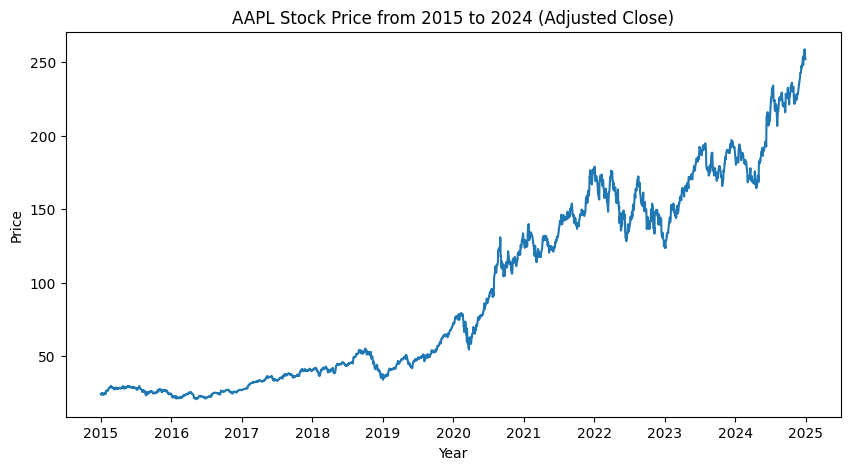

In [7]:
# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(df_adjclose_aapl.index, df_adjclose_aapl.values)

ax = plt.gca()
ax.set_title('AAPL Stock Price from 2015 to 2024 (Adjusted Close)')

# Set major ticks to show only **one tick per year**
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # One tick per year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as "YYYY"
plt.xlabel('Year')
plt.ylabel('Price')

plt.show()

In [8]:
print('(Min, Max) of AAPL:', (round(min(df_adjclose_aapl['AAPL']), 3), round(max(df_adjclose_aapl['AAPL']), 3)))

(Min, Max) of AAPL: (20.675, 258.736)


### Transformation

In [9]:
# Transform the time-series dataset specifically for LSTM
def time_series_to_lstm(df, target_variable, lag_steps=1, dropna=True, fill='ffill'):
    """
    Transforms time-series data into a supervised learning format compatible with LSTMs.
    
    Args:
        df (pd.DataFrame): The input time-series dataset.
        target_variable (str): The column to predict.
        lag_steps (int): Number of past time steps to include.
        dropna (bool): Whether to drop rows with NaN values.
        fill (str): What to fill NaN values with ('ffill', 'bfill', 'mean', 'median', None)
        
    Returns:
        df_transformed (pd.DataFrame): DataFrame to be used as input for LSTM model
    """
    # Ensure dataframe format
    if isinstance(df, list):
        df = DataFrame(df)
    
    cols = []
    feature_names = []
    
    # Create Lag Steps
    for i in range(lag_steps, 0, -1):
        cols.append(df.shift(i))
        feature_names += [f"{col}(t-{i})" for col in df.columns]
    
    # Current time step (t) for target variable
    cols.append(df[[target_variable]])
    feature_names += [f"{target_variable}(t)"]
    
    # Combine and assign column names
    df_transformed = concat(cols, axis=1)
    df_transformed.columns = feature_names

    # Drop NaN rows if required
    if dropna:
        df_transformed.dropna(inplace=True)
    else:
        if not None:
            df_transformed.fillna(method=fill, inplace=True)
    
    return df_transformed

In [10]:
df_transformed = time_series_to_lstm(df_adjclose_aapl, target_variable, lag_steps)
print(df_transformed.shape)
df_transformed.head()

(2514, 2)


,AAPL(t-1),AAPL(t)
Date,,
2015-01-05,24.320435,23.635284
2015-01-06,23.635284,23.637510
2015-01-07,23.637510,23.968960
2015-01-08,23.968960,24.889904
2015-01-09,24.889904,24.916597


In [11]:
# Export transformed dataset
df_transformed.to_csv('../../data/clean/baseline_transformed_dataset_AAPL.csv')

In [12]:
# Train-Test Split
split = int(df_transformed.shape[0]*0.8)
train = df_transformed[:split]
test = df_transformed[split:]

print('Split Shape:', train.shape, test.shape)

Split Shape: (2011, 2) (503, 2)


In [13]:
# Scale to avoid distance calculation bias
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test) # Avoid data leakage

In [14]:
# Separate into features and target (last column)
X_train, y_train = train_scaled[:, :-1], train_scaled[:, -1]
X_test, y_test = test_scaled[:, :-1], test_scaled[:, -1]

In [15]:
# Reshape features for LSTM
X_train = X_train.reshape((X_train.shape[0], lag_steps, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], lag_steps, X_test.shape[1]))

print('Train Shape:', X_train.shape, y_train.shape)
print('Test Shape:', X_test.shape, y_test.shape)

Train Shape: (2011, 1, 1) (2011,)
Test Shape: (503, 1, 1) (503,)


## LSTM

### Training

In [16]:
# Initiate LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

/Users/xaviersan/.pyenv/versions/multimodal_stockprice_predictor/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
21/21 - 1s - 39ms/step - loss: 0.2394 - val_loss: 0.8185
Epoch 2/50
21/21 - 0s - 4ms/step - loss: 0.1932 - val_loss: 0.6951
Epoch 3/50
21/21 - 0s - 4ms/step - loss: 0.1795 - val_loss: 0.6046
Epoch 4/50
21/21 - 0s - 3ms/step - loss: 0.1661 - val_loss: 0.5313
Epoch 5/50
21/21 - 0s - 3ms/step - loss: 0.1490 - val_loss: 0.4593
Epoch 6/50
21/21 - 0s - 4ms/step - loss: 0.1289 - val_loss: 0.3791
Epoch 7/50
21/21 - 0s - 4ms/step - loss: 0.1065 - val_loss: 0.2879
Epoch 8/50
21/21 - 0s - 4ms/step - loss: 0.0812 - val_loss: 0.1840
Epoch 9/50
21/21 - 0s - 4ms/step - loss: 0.0522 - val_loss: 0.0644
Epoch 10/50
21/21 - 0s - 3ms/step - loss: 0.0238 - val_loss: 0.0379
Epoch 11/50
21/21 - 0s - 4ms/step - loss: 0.0140 - val_loss: 0.0301
Epoch 12/50
21/21 - 0s - 5ms/step - loss: 0.0137 - val_loss: 0.0329
Epoch 13/50
21/21 - 0s - 5ms/step - loss: 0.0308 - val_loss: 0.0234
Epoch 14/50
21/21 - 0s - 4ms/step - loss: 0.0151 - val_loss: 0.0351
Epoch 15/50
21/21 - 0s - 4ms/step - loss: 0.0093 - val_l

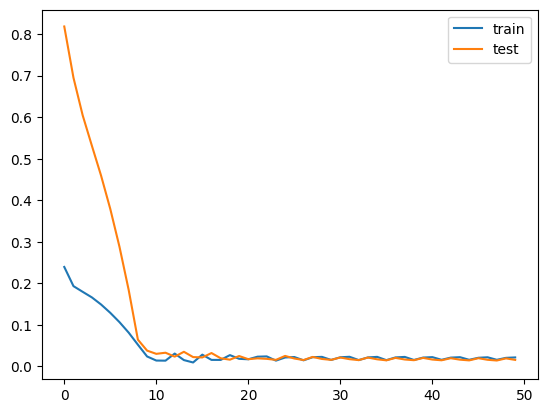

In [17]:
# Model fitting
history = model.fit(X_train, y_train, epochs=50, batch_size=96, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot training progression
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Predictions

In [18]:
# Get predicted values
yhat = model.predict(X_test)

# Reshaping back into 2D for inverse scaling
X_test_inv = X_test.reshape((X_test.shape[0], X_test.shape[2])) 

# Concatenate and Inverse Scaling
# Prediction
inv_yhat = concatenate((X_test_inv, yhat), axis=1) # Required to get back original scale
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, num_features*lag_steps] # Extract target_variable

# Validation
y_test_inv = y_test.reshape((len(y_test), 1))
inv_y = concatenate((X_test_inv, y_test_inv), axis=1) # Both arrays must have same dimensions
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, num_features*lag_steps]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [19]:
# Get Test Errors
mae = mean_absolute_error(inv_y, inv_yhat)
print('LSTM Test MAE: %.3f' % mae)

mse = mean_squared_error(inv_y, inv_yhat)
print('LSTM Test MSE: %.3f' % mse)

LSTM Test MAE: 2.463
LSTM Test MSE: 10.880


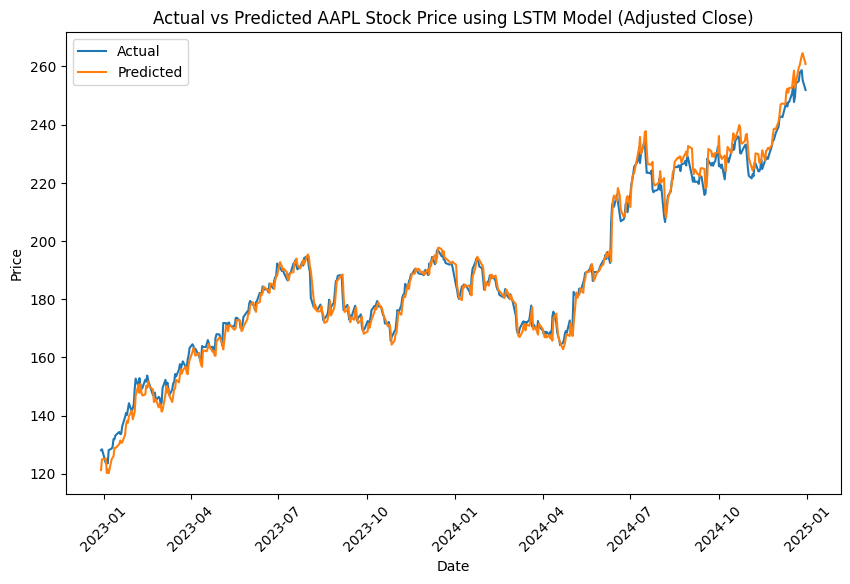

In [20]:
# Validation plot
plt.figure(figsize=(10, 6))
plt.plot(test.index, inv_y, label='Actual')
plt.plot(test.index, inv_yhat, label='Predicted')

# Format the x-axis to show quarterly ticks
plt.gca().xaxis.set_major_locator(mdates.MonthLocator((1,4,7,10)))  # Quarterly ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as Year-Quarter

# Labels and title
plt.title('Actual vs Predicted AAPL Stock Price using LSTM Model (Adjusted Close)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Price')
plt.legend()
plt.show()